# ML Assignment 2


##  Team Members

-  Aitazaz  Ali,  s4004062

## 1. Introduction

- **Bullet Points Overview:**
  - **Goal:** Build predictive models for classifying histopathelogy images of collon cells:
    - *cellType*: need to classify type of cell.
    - *isCancerous*: need to classify if cell is a cancerous cell.

---

## 2. Exploratory Data Analysis (EDA)

# Handling Imbalanced Data

### Cancerous vs Not Cancerous

- It is **Imbalanced**: (See Figure 1)
  - ~ 6,000 nonCancerous examples
  - ~ 4,000 isCancerous examples
- If the model guesses (without learning) nonCancerous 60% of the time, it would achieve 60% accuracy on the training set.
- Therefore, need robust performance metrics: **F1-Score**.
- The model could **overfit** to predicting *not cancerous*.
  - To prevent this, ensure that **train, validation, and test sets** have a valid distribution of both classes.
  - This ensures that **overfitting is detected** when poor predictions are reflected in performance metrics.

## Cell Type Classification

- Cell type also **Imbalanced** (See Figure 2):
  - Type 2: ~4,000 examples
  - Type 1: ~2,500 examples
  - Type 0: ~2,000 examples
  - Type 3: ~1,500 examples
- If the model **guesses** Type 2 cells 40% of the time (without learning patterns), it would achieve 40% accuracy.
- The model may not learn **characteristic patterns** for each cell type equally.
  - Learning patterns for just Type 1 and Type 2 could lead to ~65% accuracy.

## Other Insights Into Potential Issues



- There is no null values in any column of dataset.
- See figure 9, 10, 11 for some example images of each cellType
    - None suffer from embedded text issues
    - Given it is a 27x27 image and We are still able to decipher the shapes of the cells. It does not seem suffer from problematic blur.   

## Addressing Class Imbalance

- Use robust performance metrics (F1-Score) and validation techniques to reduce the effects of class imbalance.
- **Cross-validation** can provide a more robust estimate of model performance by evaluating across multiple data subsets.
  - Helps expose the model to different training set distributions.
- **Augmentation** can help balance class distributions.
- Aim to construct batches that equally represent all classes.
  - But this can be difficult to implement effectively.

---
## 2. Data Splitting and Approach

## Data Splitting Strategy

- The ~9000 images are from 60 patients (main dataset). Each patient has different count of cellTypes (See Figure 4, 5, 6, 7). But only the epithelial cells show cancerous status in the main set. (See Figure 3)  
  - There is ~4000 cancerous cell types, all are epithelial cells but not all patients have epithelial cells. (See Figure 3)

- **What we will do**
  - We split the examples based on patientID
  - We divide patients into three groups: test, validation and train 
      - Each group will have relatively same amount cancerous vs non-cancerous as is present in the whole dataset. (~40% ) 
        - This ensures each group is a good representative of the whole dataset. 
      - Each group will also have relatively same amount of each cellType as is representative of the whole dataset. 
        - Therefore, need to ensure patients grouped for each split can provide sufficient images of each cellType.  
    - This could cause high variance as the train split is not good representative 
    - This could cause high bias as the model starts to guess/make assumptions about the patterns instead of learning. 

---
## 3. Preprocessing

## Data Handling Methods

-  We have 9896 pictures. However, there is class imbalance. Could augment existing images for certain class types to get balanced classes. 
-  We can use **normalisation**. Helps model learn patterns. Each pixel of image is a feature. The network learns how important each feature is.  Normalising helps the network fairly evaluate how important each pixel really is.  Otherwise, they might over prioritise pixels with higher values in the learning process. 
-  **Data Augmentation** to help data imbalance by creating more examples of miniority classes. 

---


In [4]:
# import zipfile
# with zipfile.ZipFile('./Image_classification_data.zip', 'r') as zip_ref:
#     zip.ref.extractall('./')

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

data = pd.read_csv('./Image_classification_data/data_labels_mainData.csv')
data.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB
None


Check if any nulls 
InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64


Summary data statistics 
         InstanceID    patientID     cellType  isCancerous
count   9896.000000  9896.000000  9896.000000  9896.000000
mean   10193.880154    29.762025     1.501516     0.412187
std     6652.912660    17.486553     0.954867     0.492253
min        1.000000     1.000000     0.000000     0.000000
25%     4135.750000    14.000000    

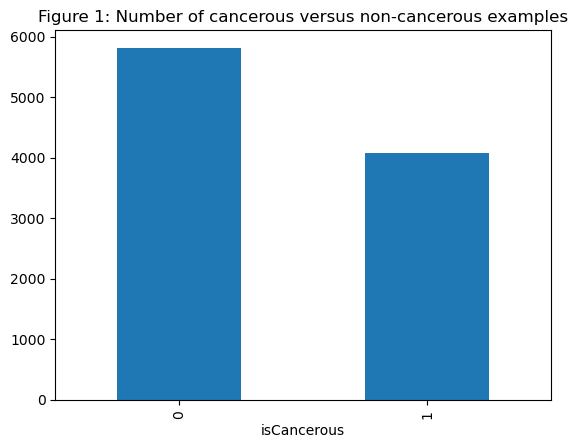

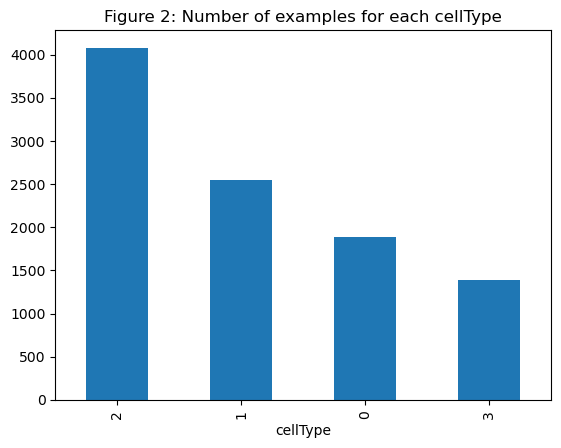

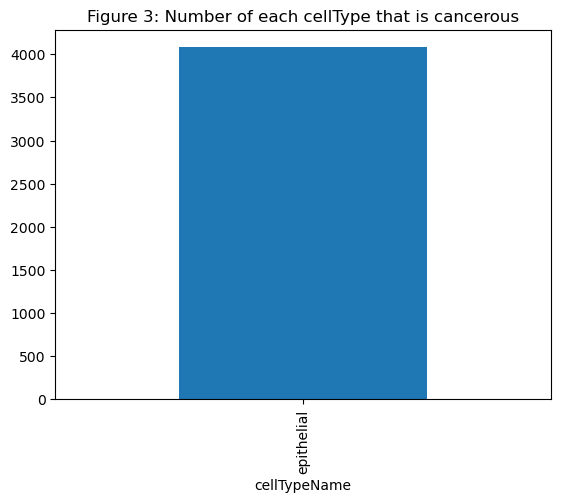

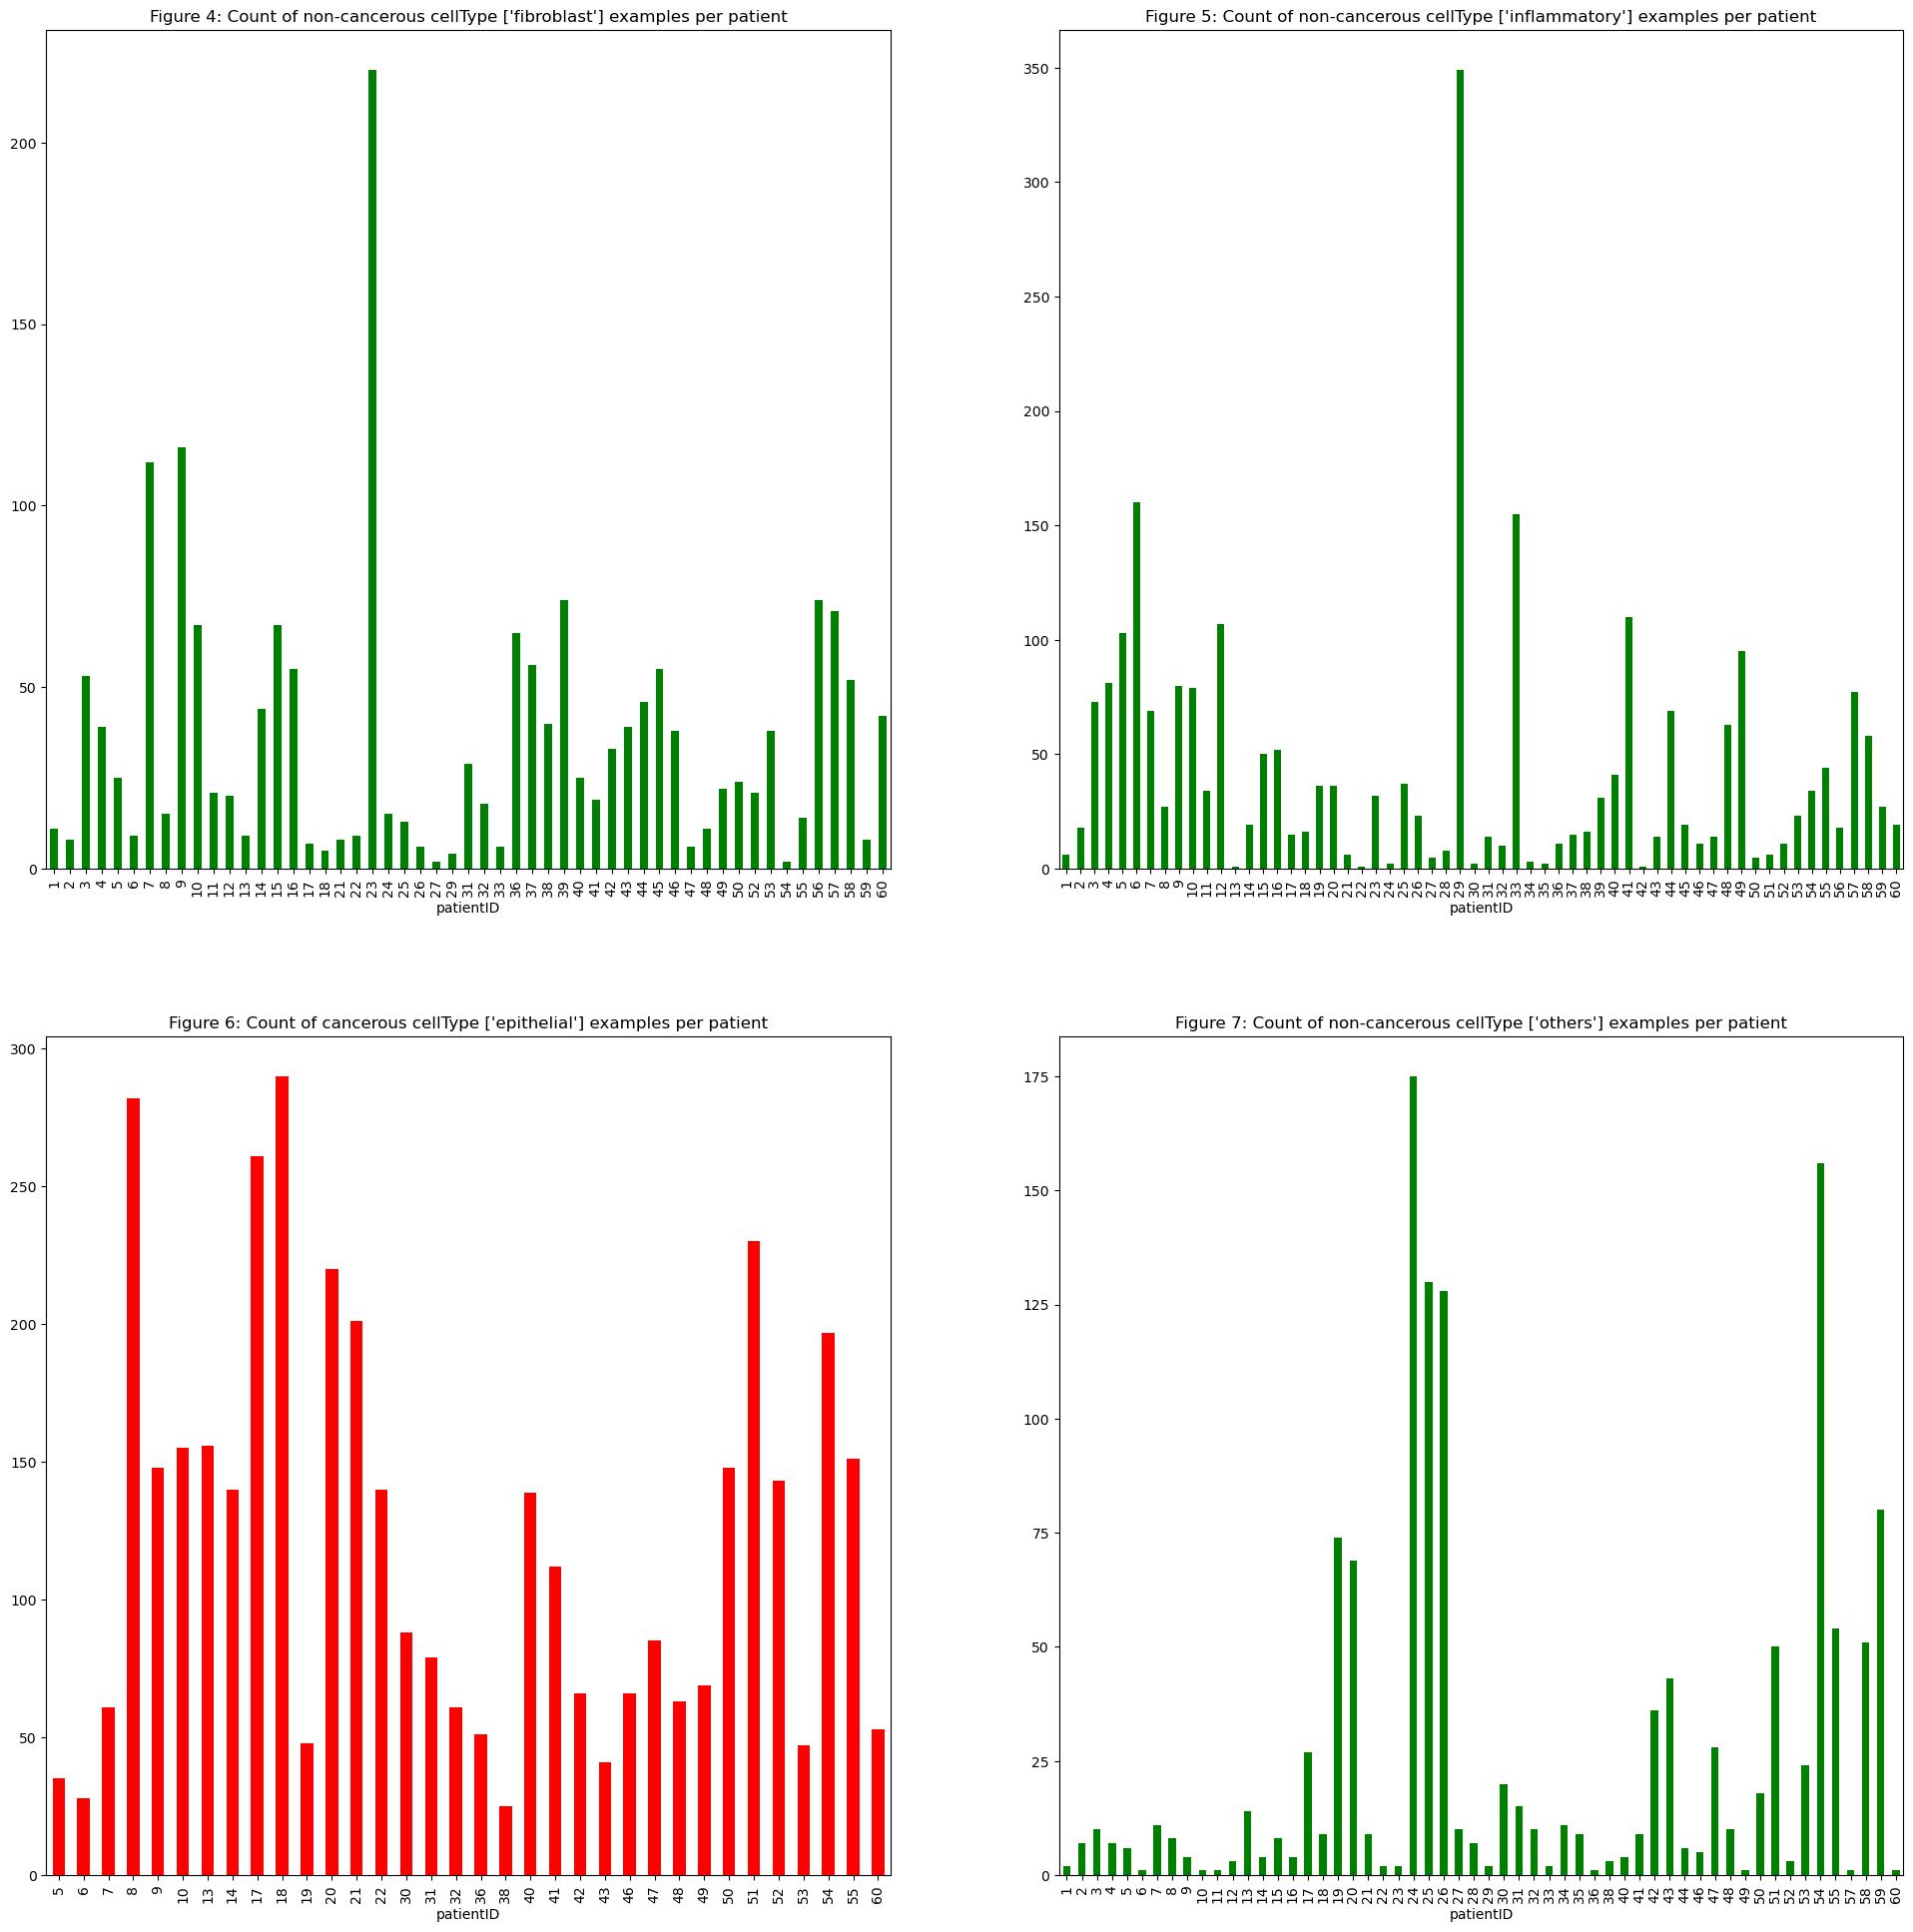

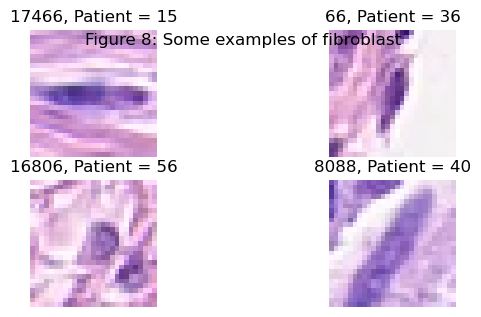

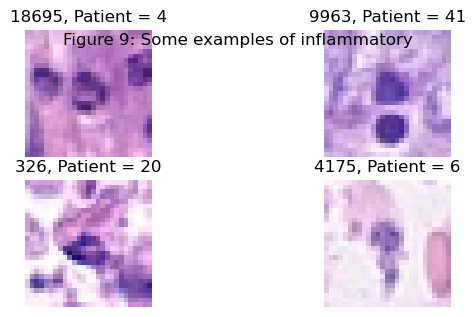

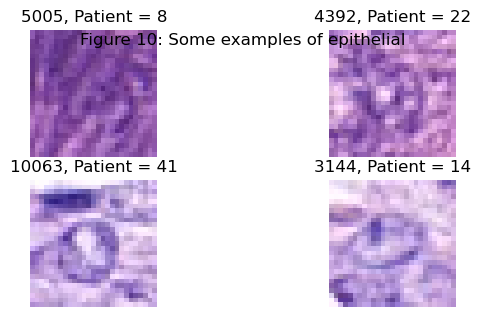

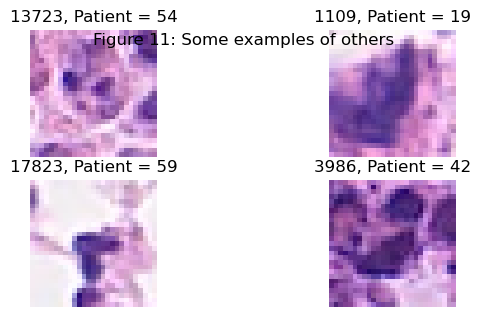

In [2]:
# from PIL import Image
import matplotlib.pyplot as plt
from skimage.feature import hog
# from skimage import data, exposure
from skimage.io import imread
from skimage.color import rgba2rgb, rgb2gray

print(data.info())
print(f'\n\nCheck if any nulls \n{data.isnull().sum()}')
print(f'\n\nSummary data statistics \n{data.describe()}')


# Below plots show count for isCancerous and cellType.
# Also the plot for which isCancerous count for each cellType 
data['isCancerous'].value_counts().plot(kind='bar', title='Figure 1: Number of cancerous versus non-cancerous examples')
plt.show()
data['cellType'].value_counts().plot(kind='bar', title='Figure 2: Number of examples for each cellType')
plt.show()
data[data['isCancerous'] == 1]['cellTypeName'].value_counts().plot(kind='bar', title='Figure 3: Number of each cellType that is cancerous')
plt.show()


# Below plots the amount of each cellType for each patientID
plt.figure(figsize=(24, 24))
figindex = 3
for i in range(0, 4):
    plt.subplot(2, 2, i + 1)
    # Get rows where cellType = i and get value count of each patientID (how many patients have that cellType)
    byCellTypeCountCancerous = data[(data['cellType'] == i) & (data['isCancerous'] == 1)]['patientID'].value_counts().sort_index()
    byCellTypeCountNotCancerous = data[(data['cellType'] == i) & (data['isCancerous'] == 0)]['patientID'].value_counts().sort_index()
    if len(byCellTypeCountCancerous) > 0:
        figindex += 1
        byCellTypeCountCancerous.plot(kind='bar', color='red', title=f'Figure {figindex}: Count of cancerous cellType {data[data['cellType'] == i]['cellTypeName'].unique()} examples per patient')
    if len(byCellTypeCountNotCancerous) > 0:
        figindex += 1
        byCellTypeCountNotCancerous.plot(kind='bar', label='isCancerous = 0', color='green', title=f'Figure {figindex}: Count of non-cancerous cellType {data[data['cellType'] == i]['cellTypeName'].unique()} examples per patient')
    
plt.show()

# Below plots example images for each cellType
import math

figIndex = 7
celltype_dict = {}
for cell in data['cellType'].unique():
    celltype_dict[cell] = data[data['cellType'] == cell]


for i in range (len(celltype_dict)):
    celltype = celltype_dict[i]
    num = 8
    col = 2
    row = math.ceil(num/col)
    plt.figure(figsize=(col * 3, row * 3))
    sample = celltype.sample(n=4)
    for j in range(len(sample)):
        image_path = sample.iloc[j]['ImageName']
        im = imread(f'./Image_classification_data/patch_images/{image_path}', as_gray=False, plugin=None)
        plt.subplot(num, col, j + 1)
        plt.title(f'{sample.iloc[j]['InstanceID']}, Patient = {sample.iloc[j]['patientID']}')
        plt.imshow(im, cmap=plt.cm.gray)
        plt.axis('off')
    plt.tight_layout(pad=0.1, h_pad=0.2, w_pad=0.0)
    figindex += 1
    plt.suptitle(f'Figure {figindex}: Some examples of {sample.iloc[1]['cellTypeName']}')
    plt.show()

In [ ]:
# Data splitting for base model

patient_dict = {}
for id  in data['patientID'].unique():
    patient_dict[id] = data[data['patientID'] == id]

patients_groupByCancerous = {}
patients_groupByNonCancerous = {}
for id, value in patient_dict.items():
    if patient_dict[id]['isCancerous'].eq(1).any():
        patients_groupByCancerous[id] = value
    else:
        patients_groupByNonCancerous[id] = value

print(f'Total number of patients is: {len(patients_groupByCancerous) + len(patients_groupByNonCancerous)}')
print(f'With {len(patients_groupByCancerous)} patients with a cancerous cell versus {len(patients_groupByNonCancerous)} patients with no cancerous cells')

# cancerousExamples = data[data['isCancerous'] == 1]
# nonCancerousExamples = data[data['isCancerous'] == 0]

# cancerousExamples_groupbypatient = {}
# for id in cancerousExamples['patientID'].unique():
#     cancerousExamples_groupbypatient[id] = cancerousExamples[cancerousExamples['patientID'] == id]

# nonCancerousExamples_groupbypatient = {}
# for id in nonCancerousExamples['patientID'].unique():
#     nonCancerousExamples_groupbypatient[id] = nonCancerousExamples[nonCancerousExamples['patientID'] == id]

TRAIN_SPLIT_PERCENT = 0.80
VALID_SPLIT_PERCENT = 0.20
TEST_SPLIT_PERCENT = 0.80
TOTAL_IMAGES = len(data)
RATIO = len(data[data['isCancerous'] == 1]) / TOTAL_IMAGES

train = pd.DataFrame(columns=data.columns)
test = pd.DataFrame(columns=data.columns)
val = pd.DataFrame(columns=data.columns)

# Pick random patients from canerous and non cancerous group 
train_split_Cancerous_keys = pd.DataFrame(list(patients_groupByCancerous.keys()), columns=['patientID']).sample(frac=TRAIN_SPLIT_PERCENT, random_state=10).reset_index(drop=True)
train_split_nonCancerous_keys = pd.DataFrame(list(patients_groupByNonCancerous.keys()), columns=['patientID']).sample(frac=TRAIN_SPLIT_PERCENT, random_state=10).reset_index(drop=True)

# From the train set pick random patients for val set
val_split_Cancerous_keys = train_split_Cancerous_keys.sample(frac=VALID_SPLIT_PERCENT, random_state=10).reset_index(drop=True)
val_split_nonCancerous_keys = train_split_nonCancerous_keys.sample(frac=VALID_SPLIT_PERCENT, random_state=10).reset_index(drop=True)


print(f'- For train set, picked {len(train_split_Cancerous_keys)} patients out of {len(patients_groupByCancerous)} patients with cancerous cells')
# print(f'They are \n {train_split_Cancerous_keys}')
print(f'- For train set, picked {len(train_split_nonCancerous_keys)} patients out of {len(patients_groupByNonCancerous)} patients with non cancerous cells')
print(f'- Therefore, there is a ratio of cancerous to total patients in train set of {len(train_split_Cancerous_keys)/(len(train_split_nonCancerous_keys) + len(train_split_Cancerous_keys))} ')
print(f'- Therefore, there is a ratio of cancerous to total patients in test set of {(len(train_split_Cancerous_keys ) - len(patients_groupByCancerous)) /(len(train_split_nonCancerous_keys) + len(train_split_Cancerous_keys) - (len(patients_groupByNonCancerous) + len(patients_groupByCancerous)))} ')

print(f'- For val set, picked {len(val_split_Cancerous_keys)} patients out of {len(train_split_Cancerous_keys)} train set patients with cancerous cells')
print(f'- For val set, picked {len(val_split_nonCancerous_keys)} patients out of {len(train_split_nonCancerous_keys)} train set patients with non cancerous cells')
print(f'- Therefore, there is a ratio of cancerous to total patient in val set of {len(val_split_Cancerous_keys)/(len(val_split_Cancerous_keys) + len(val_split_nonCancerous_keys))}')

# Now based on picks for train set place the patients in the train set otherwise in the test set.
for id, key in patients_groupByCancerous.items():
    # If key of patient is selected for train then place it in the train set else in the test set
    if train_split_Cancerous_keys['patientID'].eq(id).any():
        if val_split_Cancerous_keys['patientID'].eq(id).any():
            val = pd.concat([val, patients_groupByCancerous[id]], ignore_index=True)
        else:
            train = pd.concat([train, patients_groupByCancerous[id]], ignore_index=True)
    else:
        test = pd.concat([test, patients_groupByCancerous[id]], ignore_index=True)

for id, key in patients_groupByNonCancerous.items():
    # If key of patient is selected for train then place it in the train set else in the test set
    if train_split_nonCancerous_keys['patientID'].eq(id).any():
        if val_split_nonCancerous_keys['patientID'].eq(id).any():
            val = pd.concat([val, patients_groupByNonCancerous[id]], ignore_index=True)
        else:
            train = pd.concat([train, patients_groupByNonCancerous[id]], ignore_index=True)
    else:
        test = pd.concat([test, patients_groupByNonCancerous[id]], ignore_index=True)

print(f'- There is {len(train['patientID'].unique())} patients in the train set. The count for each cell type is:\n{train['cellType'].value_counts()}')
print(f'- There is {len(val['patientID'].unique())} patients in the val set. The count for each cell type is:\n{val['cellType'].value_counts()}')
print(f'- There is {len(test['patientID'].unique())} patients in the test set. The count for each cell type is:\n{test['cellType'].value_counts()}')
print(f'- Therefore, ratio of train to total is: {len(train)/ len(data)} versus the ratio of test to total: {len(test)/len(data)}')
print(f'- Therefore, ratio of val to train is: {len(val)/len(train)}, and the ratio of val to total is: {len(val)/len(data)}') 

print(f'- The value counts for isCancerous for train set is:\n{train['isCancerous'].value_counts()}')
print(f'- The value counts for isCancerous for val set is:\n{val['isCancerous'].value_counts()}')
print(f'- The value counts for isCancerous for test set is:\n{test['isCancerous'].value_counts()}')
print(f'- The value counts for isCancerous for whole data set is:\n{data['isCancerous'].value_counts()}')



Total number of patients is: 60
With 34 patients with a cancerous cell versus 26 patients with no cancerous cells
- For train set, picked 27 patients out of 34 patients with cancerous cells
- For train set, picked 21 patients out of 26 patients with non cancerous cells
- Therefore, there is a ratio of cancerous to total patients in train set of 0.5625 
- Therefore, there is a ratio of cancerous to total patients in test set of 0.5833333333333334 
- For val set, picked 5 patients out of 27 train set patients with cancerous cells
- For val set, picked 4 patients out of 21 train set patients with non cancerous cells
- Therefore, there is a ratio of cancerous to total patient in val set of 0.5555555555555556
- There is 39 patients in the train set. The count for each cell type is:
cellType
2    2630
0    1454
1    1447
3     930
Name: count, dtype: int64
- There is 9 patients in the val set. The count for each cell type is:
cellType
1    679
2    553
0    222
3    158
Name: count, dtype: i

In [4]:
def KFoldSplit(folds, train_split_percent):

    KFOLD_TRAIN_SPLIT_PERCENT = train_split_percent
    KFOLD_VALID_SPLIT_PERCENT = 1 / folds
    KFOLD_TEST_SPLIT_PERCENT = 1 - train_split_percent

    KFOLD_TOTAL_IMAGES = len(data)
    KFOLD_RATIO = len(data[data['isCancerous'] == 1]) / TOTAL_IMAGES

    # initialise the columns
    # train = pd.DataFrame(columns=data.columns)
    KFOLD_test = pd.DataFrame(columns=data.columns)
    # val = pd.DataFrame(columns=data.columns)
    folds_keys = {}
    folds_dict = {}
    for i in range(0, folds):
        folds_dict[i] = pd.DataFrame(columns=data.columns)
        folds_keys[i] = ()

    # Pick random patients from canerous and non cancerous group 
    KFOLD_train_split_Cancerous_keys = pd.DataFrame(list(patients_groupByCancerous.keys()), columns=['patientID']).sample(frac=KFOLD_TRAIN_SPLIT_PERCENT, random_state=10).reset_index(drop=True)
    KFOLD_train_split_nonCancerous_keys = pd.DataFrame(list(patients_groupByNonCancerous.keys()), columns=['patientID']).sample(frac=KFOLD_TRAIN_SPLIT_PERCENT, random_state=10).reset_index(drop=True)

    # From the train set pick random patients for each fold.
    # We do first fold manually so we have keys to pick the next fold from.
    # To find split percent we use formula (number of fold keys - (number of train keys / folds)) / number of keys
    # or: (size of fold key pool - target size of each fold) / size of fold key pool
    # folds_keys[0] = (train_split_Cancerous_keys.sample(frac=((len(train_split_Cancerous_keys)) - (len(train_split_Cancerous_keys)/folds)) / len(train_split_Cancerous_keys),
    #                                                     random_state=10).reset_index(drop=True), 
    #                  train_split_nonCancerous_keys.sample(frac=((len(train_split_Cancerous_keys)) - (len(train_split_Cancerous_keys)/folds)) / len(train_split_Cancerous_keys),
    #                                                        random_state=10).reset_index(drop=True))

    # pool of keys to pick the next fold from.
    # initally the pool is same as train keys pool but each (sequential) fold uses pool of previous fold
    # where each sequntial fold picks from keys in the pool provided by the previous fold
    # this enables the splitting. for train we pick examples not in fold 1. for fold 1 we pick examples not in fold  2. etc... 
    pool_split_Cancerous_keys = KFOLD_train_split_Cancerous_keys
    pool_split_nonCancerous_keys = KFOLD_train_split_nonCancerous_keys

    fold_cancerous_split = 1
    fold_nonCancerous_split = 1

    for idx, fold in folds_keys.items():
        

        folds_keys[idx] = (pool_split_Cancerous_keys.sample(frac=fold_cancerous_split, random_state=10).reset_index(drop=True), 
                     pool_split_nonCancerous_keys.sample(frac=fold_nonCancerous_split, random_state=10).reset_index(drop=True))
        
        pool_split_Cancerous_keys = folds_keys[idx][0]
        pool_split_nonCancerous_keys = folds_keys[idx][1] 
        

        fold_cancerous_split = (len(pool_split_Cancerous_keys) - (len(KFOLD_train_split_Cancerous_keys)/folds)) / len(pool_split_Cancerous_keys)
        fold_nonCancerous_split = (len(pool_split_nonCancerous_keys) - (len(KFOLD_train_split_nonCancerous_keys)/folds)) / len(pool_split_nonCancerous_keys)


    # now we have key pool splits where train contains pool of keys, fold1 contains pool of keys for fold2 ...  
    # here is the spool venn diagram(kind of)     [train [fold1 [fold 2 [fold 3 [fold 4]]]]]


    print(f'- For train set, picked {len(KFOLD_train_split_Cancerous_keys)} patients out of {len(patients_groupByCancerous)} patients with cancerous cells')
    # print(f'They are \n {train_split_Cancerous_keys}')
    print(f'- For train set, picked {len(KFOLD_train_split_nonCancerous_keys)} patients out of {len(patients_groupByNonCancerous)} patients with non cancerous cells')
    print(f'- Therefore, there is a ratio of cancerous to total patients in train set of {len(KFOLD_train_split_Cancerous_keys)/(len(KFOLD_train_split_nonCancerous_keys) + len(KFOLD_train_split_Cancerous_keys))} ')
    print(f'- Therefore, there is a ratio of cancerous to total patients in test set of {(len(KFOLD_train_split_Cancerous_keys ) - len(patients_groupByCancerous)) /(len(KFOLD_train_split_nonCancerous_keys) + len(KFOLD_train_split_Cancerous_keys) - (len(patients_groupByNonCancerous) + len(patients_groupByCancerous)))} ')

    for idx, fold in folds_keys.items():
        print(f'- For fold set {idx}, picked {len(fold[0])} patients out of {len(KFOLD_train_split_Cancerous_keys)} train set patients with cancerous cells')
        print(f'- For fold set {idx}, picked {len(fold[1])} patients out of {len(KFOLD_train_split_nonCancerous_keys)} train set patients with non cancerous cells')
        print(f'- Therefore, there is a ratio of cancerous to total patient in fold set {idx} of {len(fold[0])/(len(fold[0]) + len(fold[1]))}')


    # Now based on picks for train (and each fold) set place the patients in the train set (and each fold) otherwise in the test set.
    for id, key in patients_groupByCancerous.items():
        # If key of patient is selected for train then place it in the train set (in one of the folds) else in the test set
        if KFOLD_train_split_Cancerous_keys['patientID'].eq(id).any():
            target_fold = 0
            # iterate through all folds (1..2..3) then return the index last of last fold to have the key
            # the example belongs to that last fold.  refer to [train [fold1 [fold 2 [fold 3 [fold 4]]]]] for  why
            for idx, fold in folds_keys.items():
                if fold[0]['patientID'].eq(id).any():
                    target_fold = idx
                    
            folds_dict[target_fold] = pd.concat([folds_dict[target_fold], patients_groupByCancerous[id]], ignore_index=True)
            print(f'Adding isCancerous: patient:{id} to fold {target_fold}')
        else:
            KFOLD_test = pd.concat([KFOLD_test, patients_groupByCancerous[id]], ignore_index=True)

    for id, key in patients_groupByNonCancerous.items():
        # If key of patient is selected for train then place it in the train set else in the test set
        if KFOLD_train_split_nonCancerous_keys['patientID'].eq(id).any():
            target_fold = 0
            for idx, fold in folds_keys.items():
                if fold[1]['patientID'].eq(id).any():
                    target_fold = idx

            folds_dict[target_fold] = pd.concat([folds_dict[target_fold], patients_groupByNonCancerous[id]], ignore_index=True)
            print(f'Adding NonCancerous: patient{id} to fold {target_fold}')
        else:
            KFOLD_test = pd.concat([KFOLD_test, patients_groupByNonCancerous[id]], ignore_index=True)

        totLen = 0; 
    for idx, fold in folds_dict.items():
        print(f'- There is {len(fold['patientID'].unique())} patients in the fold set {idx}. The count for each cell type is:\n{fold['cellType'].value_counts()}')
        totLen += len(fold)

    print(f'- There is {len(train['patientID'].unique())} patients in the train set.')
    print(f'- There is {len(KFOLD_test['patientID'].unique())} patients in the test set. The count for each cell type is:\n{KFOLD_test['cellType'].value_counts()}')
    print(f'- Therefore, ratio of train to total is: {totLen/ len(data)} versus the ratio of test to total: {len(KFOLD_test)/len(data)}')

    for idx, fold in folds_dict.items():
        print(f'- Therefore, ratio of fold set {idx} to train is: {len(fold)/totLen}, and the ratio of fold set {idx} to total is: {len(fold)/len(data)}') 


    # print(f'- The value counts for isCancerous for train set is:\n{train['isCancerous'].value_counts()}')
    totLenCancerous = 0
    for idx, fold in folds_dict.items():
        print(f'- The value counts for isCancerous for fold set {idx} is:\n{fold['isCancerous'].value_counts()}')
        totLenCancerous += len(fold[fold['isCancerous'] == 1])
    
    print(f'- The value counts for isCancerous for train set is:\n{totLenCancerous}')
    print(f'- The value counts for isCancerous for test set is:\n{KFOLD_test['isCancerous'].value_counts()}')
    print(f'- The value counts for isCancerous for whole data set is:\n{data['isCancerous'].value_counts()}')

    return (folds_dict, KFOLD_test)
# I could make the splitter above modular but cannot be bothered for

##  4. Base Model & Performence Metric Selection
## Performance Metrics Selection 
-  **Best choice is F1 Score**.
  - It is harmonic mean of precision and recall. 
    - Therefore, if f1 score high then precision and recall both high and close in value.
    - Precision is being correct about positive predictions. Recall is recognising potential positive classes.
      - High precision often means lower recall as model becomes critical.
    - In an imbalanced dataset, a model guessing everything as one class leads to lower precision
      - Whereas, model unable to guess any positive values leads to low recall
    - We need both to be high in imbalanced dataset therefore F1 Score

## Base Model Selection & Justification
- CNN versus MLP for cellType classification
  - The problem with MLP is the large amount of layers required to achieve performance comparable to CNN.
    - This is because MLP tries to find/learn patterns using all the pixels at once. Not considering relevance of the pixel to the problem.
       - Seeing Figure 8, 9, 10, 11 we can notice how some pixels do provide any meaningful information yet the MLP will still utilise that to identify some abstract pattern. This means it struggles to learn meaningful patterns.
    - This means more layers are required to gain/learn enough high-level abstract patterns that can meaningfully idenitfy features of the image.
    - Consequently, more training would be required.
    - This could be solved by first applying some kernel function to highlight the relevant features of the images.
      - But if this is the aim, then a CNN is better at finding and using kernal to create new features maps (convolutional layers) from which high-level abstract patterns are created. Which are used to idenitfy patterns for classification


-  CNN versus MLP for isCancerous classification
    - Given in our EDA (see Figure 3) we noted how only epithelial cells are isCancerous we could build a MLP that just learns to identify a epithelial cell.
    - However such would be naive as this (epithelial cells only cancerous) could be feature of the dataset we are using but not of the real world.
    - Therefore, it is the best idea to learn to identify characteristics of a cancerousCell.
      - But if the dataset does not offer such examples of cancerousCells that are not epithelial then any model will equate characteristics of epithelial to cancerous
    - Nonetheless, even the simple case of a model learning characteristics of epithelial, CNN will perform better as explained above (CNN vs MLP for cellType)



## Base Model Development
- We will use F1-Score.
- Aim for a (weighted) F1-Score of ~0.86 for isCancerous and ~0.70 for isCellType. As is achieved by the VGG Architecture Models in https://github.com/nischaybikramthapa/colon-cancer-detection.
- Reason for weighted is it is ideal for class imbalanced datasets
  - The forumula is: Weighted F1 Score = Sum (i=1 to number of classes) w_i * F1_score_i
  - [text](https://www.v7labs.com/blog/f1-score-guide)
- We will also use class_weight in the keras.fit()
  - This parameter applies weights to the loss function so that the model pays more attention to samples from underrepresented classes.
  - Essentially, misclassifying samples from underrepresented classes incurs a higher loss, encouraging the model to learn more from these examples and improve its performance on them.
- Using data augmentation to help with data imbalance. Data augmentation basically applies random changes to the each images before it sends them to training.
  - This does not mean the amount of actual images increases.  Just each time an example is chosen some changes are made to it.
- Class weights and data augmentation will cause the training loss to be higher for training due to a harder training set.
  - But this makes it usually perform better on the validation set.
---


In [ ]:
# Class Weights 
cell_class_weights = {}
maxV = max(train['cellType'].value_counts())
for i in range(0, 4):
    cell_class_weights[i] = maxV/len(train[train['cellType'] == i])

isCancerous_class_weights = {}
maxV = max(train['isCancerous'].value_counts())
for i in range(0, 2):
    isCancerous_class_weights[i] = maxV/len(train[train['isCancerous'] == i])


In [6]:
# Data generator + Augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

OUTPUT_CLASSES_CELLTYPE = 4
OUTPUT_CLASSES_ISCANCEROUS = 2
def DataGenerator(train_set, val_set, b_size):
    

    # For some reason ImageDataGenerator needs classes to be strings
    train_set['cellType'] = train_set['cellType'].astype(str)
    val_set['cellType'] = val_set['cellType'].astype(str)

    # Lets do bit of normalisation with pixel values -> faster training
    train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                    rotation_range=15, width_shift_range=0.2,
                                    height_shift_range=0.2, brightness_range=[0.5,1.5])
    val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

    # A hyperparameter?
    batch_size = b_size

    # For cellType classification
    train_generator = train_datagen.flow_from_dataframe(
        dataframe = train_set,
        directory = './Image_classification_data/patch_images/',
        x_col = 'ImageName',
        y_col = 'cellType',
        target_size=(27, 27),
        batch_size = batch_size,
        class_mode = 'categorical', # Creates onehot encoded labels
        seed = 10,
        shuffle = True
    )

    validation_generator = val_datagen.flow_from_dataframe(
        dataframe = val_set,
        directory = './Image_classification_data/patch_images/',
        x_col = 'ImageName',
        y_col = 'cellType',
        target_size=(27, 27),
        batch_size = batch_size,
        class_mode = 'categorical',
        seed = 10,
        shuffle = True
    )

    # For cancerous classification


    train_set['isCancerous'] = train_set['isCancerous'].astype(str)
    val_set['isCancerous'] = val_set['isCancerous'].astype(str)

    

    train_generator_cancerous = train_datagen.flow_from_dataframe(
        dataframe = train_set,
        directory = './Image_classification_data/patch_images/',
        x_col = 'ImageName',
        y_col = 'isCancerous',
        target_size=(27, 27),
        batch_size = batch_size,
        class_mode = 'categorical', # Creates onehot encoded labels
        seed = 10,
        shuffle = True
    )

    validation_generator_cancerous = val_datagen.flow_from_dataframe(
        dataframe = val_set,
        directory = './Image_classification_data/patch_images/',
        x_col = 'ImageName',
        y_col = 'isCancerous',
        target_size=(27, 27),
        batch_size = batch_size,
        class_mode = 'categorical', # Creates onehot encoded labels
        seed = 10,
        shuffle = True
    )

    return (train_generator, validation_generator, train_generator_cancerous, validation_generator_cancerous)

2025-05-22 23:02:36.008362: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-22 23:02:36.027882: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-22 23:02:36.065348: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747918956.110444    8655 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747918956.123780    8655 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747918956.174797    8655 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [ ]:
# Lets use the generator to get train and val ImageDataGenerators for baseline model for cellType and isCancerous  
(train_generator, validation_generator, train_generator_cancerous, validation_generator_cancerous) = DataGenerator(train, val, 30)

Found 6461 validated image filenames belonging to 4 classes.
Found 1612 validated image filenames belonging to 4 classes.
Found 6461 validated image filenames belonging to 2 classes.
Found 1612 validated image filenames belonging to 2 classes.


In [8]:
# Model Development

import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name, suptitle):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.suptitle(f'{suptitle}')
    plt.show()

In [9]:
import tensorflow as tf


model_VGG_1 = tf.keras.Sequential([
    # First feature extraction
    #VGG block 1
    # 32 (3x3, 3 Channels) Kernels. output => 27x27, 32 Feature Maps)
    # padding = 'same': output size = input size (see ref [1])  stride = 1 (the skip between middle of kernel) 
    # padding is adjusted to ensure same size output as input  
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    # Down sampling using max pooling. Reduces size by 2.
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    # More filters to learn more complex patterns
    # Learns patterns of the patterns in features maps of above block
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(127, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Then decision maker
    # convert the ?D output tensor into a 1D Vector. if second last layer is 4x4 then (4 * 4 * 128)
    # Allows dense (fully connected) layer to make connections between activations in across many feature maps to classes?  
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES_CELLTYPE),
])


model_VGG_2 = tf.keras.Sequential([
    # First feature extraction
    #VGG block 1
    # 32 (3x3, 3 Channels) Kernels. output => 27x27, 32 Feature Maps)
    # padding = 'same': output size = input size (see ref [1])  stride = 1 (the skip between middle of kernel) 
    # padding is adjusted to ensure same size output as input  
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    # Down sampling using max pooling. Reduces size by 2.
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    # More filters to learn more complex patterns
    # Learns patterns of the patterns in features maps of above block
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(127, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Then decision maker
    # convert the ?D output tensor into a 1D Vector. if second last layer is 4x4 then (4 * 4 * 128)
    # Allows dense (fully connected) layer to make connections between activations in across many feature maps to classes?  
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES_ISCANCEROUS),
])

/home/voyage/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-22 23:02:45.388569: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [ ]:
from tensorflow.keras.metrics import Precision, Recall, F1Score
import random
import json
import random
import datetime

# Optimizer = how to update weight
# 'adam' = (Adaptive Moment Estimation) https://www.geeksforgeeks.org/adam-optimizer/
myOptimizer = tf.keras.optimizers.SGD(
    learning_rate = 0.001, # Just a bit slower than the default
    momentum = 0.9, # Classic 
    nesterov = True
)
model_VGG_1.compile(optimizer=myOptimizer,
            # IDK IF below are true for sure
            # SparseCategoricalCrossentropy expects a column with labels: 0, 1, 2, 3... then turns them into one-hot representation
            # CategoricalCrossentropy expects one-hot encoded labels: [0, 1, 0, 0]
            # from_logits means final layer doesn't have softmax activation. raw outputs. therefore keras will apply softmax inside loss func.
            # https://stackabuse.com/what-is-fromlogitstrue-in-keras-tensorflow-loss-functions/
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.F1Score(name="f1", average="weighted")]
              )
# https://neptune.ai/blog/implementing-the-macro-f1-score-in-keras
# https://www.tensorflow.org/api_docs/python/tf/keras/metrics/F1Score

# https://keras.io/api/models/model_training_apis/#:~:text=of%20every%20sample.-,class_weight%3A%20Optional%20dictionary%20mapping%20class%20indices%20(integers)%20to%20a,from%20an%20under%2Drepresented%20class.
history_VGG_1 = model_VGG_1.fit(train_generator, validation_data = validation_generator, epochs=25, verbose=1, class_weight=cell_class_weights)

rand = round(random.random, 5)
model_VGG_1.save(f"models/model_VGG_1_{rand}.keras")
with open(f"history/history_VGG_1_{rand}.history", "w") as file:
    json.dump(history_VGG_1.history, file)

In [ ]:
# isCancerous
model_VGG_2.compile(optimizer=myOptimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.F1Score(name="f1", average="weighted")]
              )

history_VGG_2 = model_VGG_2.fit(train_generator_cancerous, validation_data= validation_generator_cancerous, epochs=25, verbose=1, class_weight=isCancerous_class_weights)

rand = round(random.random, 5)
model_VGG_2.save(f"models/model_VGG_2_isCancerous_{rand}.keras")
with open(f"history/history_VGG_2_{rand}.history", "w") as file:
    json.dump(history_VGG_2.history, file)

Epoch 1/25


/home/fast/aiti/ML_Assignment2/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1747908030.226962   18375 service.cc:152] XLA service 0x7f007c00ef30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747908030.227007   18375 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-05-22 20:00:30.253605: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747908030.379795   18375 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-22 20:00:30.834392: I exter

 12/216 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - f1: 0.2343 - loss: 0.8212

I0000 00:00:1747908035.393087   18375 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


214/216 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - f1: 0.5024 - loss: 0.8198

2025-05-22 20:00:44.692610: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_127', 4 bytes spill stores, 4 bytes spill loads



216/216 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - f1: 0.5030 - loss: 0.8198 - val_f1: 0.3695 - val_loss: 0.6927
Epoch 2/25
216/216 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - f1: 0.5917 - loss: 0.8148 - val_f1: 0.7175 - val_loss: 0.6713
Epoch 3/25
216/216 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - f1: 0.7013 - loss: 0.7724 - val_f1: 0.3576 - val_loss: 0.8772
Epoch 4/25
216/216 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - f1: 0.7393 - loss: 0.6564 - val_f1: 0.8143 - val_loss: 0.4268
Epoch 5/25
216/216 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - f1: 0.7773 - loss: 0.5863 - val_f1: 0.5907 - val_loss: 0.7009
Epoch 6/25
216/216 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - f1: 0.7877 - loss: 0.5630 - val_f1: 0.7671 - val_loss: 0.4617
Epoch 7/25
216/216 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - f1: 0.8014 - loss: 0.5326 - val_f1: 0.6357 - val_loss: 0.6743
Epoch 8/25
216/216 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - f1: 0.8136 - loss: 0.4997 - val_f1: 0.6994 - val_loss: 0.5528
Epoch 9/25
216/216 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - f1: 0.8093 - loss: 

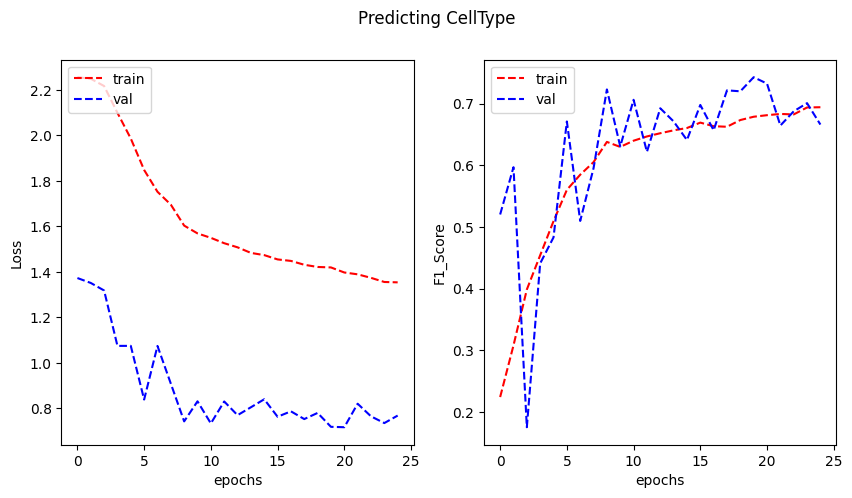

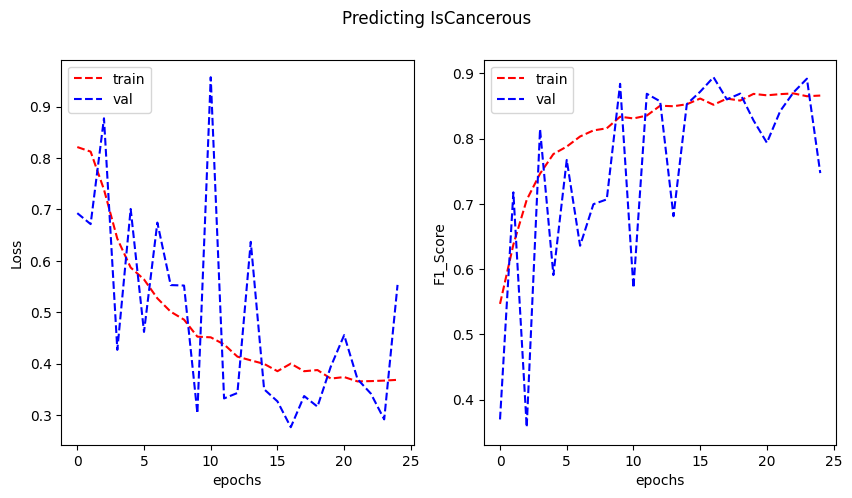

In [ ]:
figindex += 1
plot_learning_curve(history_VGG_1.history['loss'], history_VGG_1.history['val_loss'], history_VGG_1.history['f1'], history_VGG_1.history['val_f1'],
                    metric_name='F1_Score', suptitle=f"Figure {figindex}: Predicting CellType")
figindex += 1
plot_learning_curve(history_VGG_2.history['loss'], history_VGG_2.history['val_loss'], 
                    history_VGG_2.history['f1'], history_VGG_2.history['val_f1'], 
                    metric_name='F1_Score', suptitle=f"Figure {figindex}: Predicting IsCancerous")

In [ ]:
# Now lets do final evaluation
# https://www.tensorflow.org/api_docs/python/tf/keras/Model

# Need to apply same preprocessing steps to test to make it suitable as input for model
test['cellType'] = test['cellType'].astype(str)
test['isCancerous'] = test['isCancerous'].astype(str)
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

# For cellType classification
test_generator = test_datagen.flow_from_dataframe(
    dataframe = test,
    directory = './Image_classification_data/patch_images/',
    x_col = 'ImageName',
    y_col = 'cellType',
    target_size=(27, 27),
    batch_size = batch_size,
    class_mode = 'categorical', # Creates onehot encoded labels
    seed = 10,
    shuffle = False
)

# For iscancerous classification
test_generator_isCancerous = test_datagen.flow_from_dataframe(
    dataframe = test,
    directory = './Image_classification_data/patch_images/',
    x_col = 'ImageName',
    y_col = 'isCancerous',
    target_size=(27, 27),
    batch_size = batch_size,
    class_mode = 'categorical', # Creates onehot encoded labels
    seed = 10,
    shuffle = False
)

loss_base_cellType, f1_base_cellType = model_VGG_1.evaluate(test_generator)
loss_base_isCancerous, f1_base_isCancerous = model_VGG_2.evaluate(test_generator_isCancerous)

## 5. Model Optimisation
## Identifying overfitting/underfitting
- We see a large generation gap in loss cellType however f1 score is quite similar.
  - The gap in loss is explained by a more difficult training set compared to validation set.
  - The similar f1 score suggests success of our weights and augmentation to help reduce impact of the imbalanced data
  - A high f1-score suggests recall and precision are both close and high 
- On the other hand, predicting isCancerous shows a much closer loss despite harder training set.
  - But this 'harder' training set is still just images of only one cell type. Thus such performance was excepted
  - Same for the F1 score.
- The biggest problem is getting stuck in local minimums and either not having enough momemtum to get out
  - Due to computing limitations I am greedy to quick results. Hence getting stuck for 5 epochs is costly for me
  - As such model trained and hyperparams picked would not be best achieving the best score gradually (when more computing and time)
- As we see the problem is unstable learning. We keep overshooting. (possible momemtum too high or learning rate too high)
- High variance as val performance is significantly change per epoch (but no overfitting) 
- Further training as it seems the fluntuations/zigzags reduce as epochs continue. 
- More stable and smooth learning to help reduce zigzags as each epochs learning seems to head towards good performance but is very unstable. 

## Optimisation Techniques
- Reduce model complexity by switching to leNet architecture which is better for smaller images.
  - It has fewer convolutional and fully connected layers to help train faster.
  - Also reduce overfitting by not avoiding really high-level abstractions that get too tuned to the learning overly specific patterns and reduce generalisation.
- We will perform grid search with cross validation.
  - Due to our limited computing and time look for hyperparams that allow a good greedy learning (good score fast)
  - We will search two different learning rates (a higher and a lower) to see which is better for our situation (quick learning but dont get stuck in local minimums or bounce around give a high variance in performance)  
  - Above applies to momemtum as well
  - Will add dropout + regularisation to help imbalanced dataset 
    - Dropout to improve robustness of other neurons by dropping fraction of neurons so each forawrd pass is through a different subnet work
    - Allowing different parts of the network to become learn the model instead of being dominanted by a few neuron (so more of the neurons' patterns is useful)
    - Helps overfitting by reducing impact of individual neurons
    - Helps generalisation by helping each neuron identify useful patterns (activations).
    - Similarly regularisation helps weights not get too large and dominant the learning.
      - Allowing model to learn all the patterns instead of the learning just focusing on the patterns with dominant weights 


---

In [45]:
# Pipeline for next Improved model


def define_model(reg, output_classes):
    OUTPUT_CLASSES = output_classes
    reg_lambda = reg
    model_leNet_1 = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
        # Down sampling using max pooling. Reduces size by 2.
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        #LeNet block 2
        # More filters to learn more complex patterns
        # Learns patterns of the patterns in features maps of above block
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
        #LeNet block 3
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Then decision maker
        # convert the ?D output tensor into a 1D Vector. if second last layer is 4x4 then (4 * 4 * 128)
        # Allows dense (fully connected) layer to make connections between activations in across many feature maps to classes?  
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    ])
    return model_leNet_1


def trainValSetsGenerator(KFolds):
    _sets = {}
    
    # get list of the keys... [0, 1, 2, 3]
    keys_list = list(KFolds.keys())

    # for each key add to the set a train_set and a val_set
    for i in keys_list:
        # Make list of keys but without current key (i).
        # example. for  i = 0: train_keys[1,2,3] val_keys[0]
        # Then add KFold[1], KFold[2], KFold[3] to trainset
        # then add KFold[0] to val_set
        train_keys = keys_list[0:i] + keys_list[i + 1:]

        train_set = pd.DataFrame(columns=data.columns)
        for j in train_keys:
            train_set = pd.concat([train_set, KFolds[j]], ignore_index=True)
        
        val_set = pd.DataFrame(columns=data.columns)
        val_set = pd.concat([val_set, KFolds[i]], ignore_index=True)


        _sets[i] = (train_set, val_set)

    return _sets



In [ ]:
# For cellType task lets hyperparameter tune exponentialDecay learning rate, regularisation, and momemtums
# https://keras.io/api/optimizers/learning_rate_schedules/exponential_decay/

lr_schedules = {
    0: tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate = 0.01, # Not too high
        decay_steps = 8000, # Number of batches? epoches? after which to change learning rate
        decay_rate=0.95, # New rate = old rate * 0.96
        staircase = True, # staircase function
    ),
    1: tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate = 0.001, # Not too high
        decay_steps = 8000, # Number of batches? epoches? after which to change learning rate
        decay_rate=0.98, # New rate = old rate * 0.96
        staircase = True, # staircase function
    )
}
reg_lambda = [1e-4, 1e-2]
momentums = [0.8, 0.9]


# We do data splitting into KFolds
KFolds, KFold_test = KFoldSplit(3, 0.8)
# Then we get train set and val set for the different folds 
sets = trainValSetsGenerator(KFolds)

# we will use a dataframe to store parameters + mean performance + variance
# We will use this to later find the best parameters
val_scores = pd.DataFrame(columns=['reg','lr','momemtum','mean_score','variance_score'])

# grid search
for reg in reg_lambda:
    for idx, lr in lr_schedules.items():
        for m in momentums:

            # initalise the optimiser with parameters 
            optimizer = tf.keras.optimizers.SGD(
                learning_rate = lr, # the a in w_new = w_old - a * gradient(L(w))
                # momemtum adds fraction of previous update vector (dir + magnitude) to current update. 
                # velocity = momentum * velocity - learning_rate * g 
                # w = w + velocity
                momentum = m,
                nesterov=True,
            )
            # define the model with correct regularisation
            model = define_model(reg, OUTPUT_CLASSES_CELLTYPE)
            model.compile(optimizer=optimizer,
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=[tf.keras.metrics.F1Score(name="f1", average="weighted")]
            )

            # Lets store the loss (bias?) for each fold training
            cv_loss = []
            # for each kfold set (a train set and val set) do the training and store the loss results
            for idx, s in sets.items():
                train_set = s[0]
                val_set = s[1]
                train_generator, validation_generator, _, __ = DataGenerator(train_set, val_set, 27)
                
                history_leNet = model.fit(train_generator, validation_data = validation_generator, epochs=20, verbose=1, class_weight=cell_class_weights, steps_per_epoch=100) #, steps_per_epoch=50)
                cv_loss.append(history_leNet.history['val_loss'][-1]) # last epoch val loss score

            # Now lets find the mean score
            # Now lets find the variance
            # And add it to val_scores dataframe for later sorting
            new = pd.DataFrame([[reg, (lr.initial_learning_rate, lr.decay_rate), m, np.mean(cv_loss), np.var(cv_loss, ddof=1)]], columns=val_scores.columns)
            val_scores = pd.concat([val_scores, new], ignore_index=True)



In [ ]:
# we will sort by performance 
# then we will first sort by variance (since we want most stable parameters among best performers)
best_performing_hyperparams_cellType = val_scores.sort_values(by=['variance_score', 'mean_score'], ascending=[True, True]).iloc[0]
with open(f"params/cellType.params", "w") as file:
    json.dump(best_performing_hyperparams_cellType.to_json(orient='columns'), file)
with open(f"params/cellType.val_scores", "w") as file:
    json.dump(val_scores.to_json(orient='columns'), file)

In [ ]:
# For isCancerous task lets hyperparameter tune exponentialDecay learning rate, regularisation, and momemtums
reg_lambda = [1e-4, 1e-2]
momentums = [0.8, 0.9]


# We do data splitting into KFolds
KFolds, KFold_test = KFoldSplit(3, 0.8)
# Then we get train set and val set for the different folds 
sets = trainValSetsGenerator(KFolds)

# we will use a dataframe to store parameters + mean performance + variance
# We will use this to later find the best parameters
val_scores_isCancerous = pd.DataFrame(columns=['reg','lr','momemtum','mean_score','variance_score'])

# grid search
for reg in reg_lambda:
    for idx, lr in lr_schedules.items():
        for m in momentums:

            # initalise the optimiser with parameters 
            optimizer = tf.keras.optimizers.SGD(
                learning_rate = lr, # the a in w_new = w_old - a * gradient(L(w))
                # momemtum adds fraction of previous update vector (dir + magnitude) to current update. 
                # velocity = momentum * velocity - learning_rate * g 
                # w = w + velocity
                momentum = m,
                nesterov=True,
            )
            # define the model with correct regularisation
            model = define_model(reg, OUTPUT_CLASSES_ISCANCEROUS)
            model.compile(optimizer=optimizer,
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=[tf.keras.metrics.F1Score(name="f1", average="weighted")]
            )

            # Lets store the loss (bias?) for each fold training
            cv_loss = []
            # for each kfold set (a train set and val set) do the training and store the loss results
            for idx, s in sets.items():
                train_set = s[0]
                val_set = s[1]
                _, __, train_generator, validation_generator = DataGenerator(train_set, val_set, 27)
                
                history_leNet = model.fit(train_generator, validation_data = validation_generator, epochs=20, verbose=1, class_weight=isCancerous_class_weights, steps_per_epoch=100) #, steps_per_epoch=50)
                cv_loss.append(history_leNet.history['val_loss'][-1]) # last epoch val loss score

            # Now lets find the mean score
            # Now lets find the variance
            # And add it to val_scores dataframe for later sorting
            new = pd.DataFrame([[reg, (lr.initial_learning_rate, lr.decay_rate), m, np.mean(cv_loss), np.var(cv_loss, ddof=1)]], columns=val_scores.columns)
            val_scores_isCancerous = pd.concat([val_scores_isCancerous, new], ignore_index=True)





In [ ]:
best_performing_hyperparams_isCancerous = val_scores_isCancerous.sort_values(by=['variance_score', 'mean_score'], ascending=[True, True]).iloc[0]
with open(f"params/isCancerous.params", "w") as file:
    json.dump(best_performing_hyperparams_isCancerous.to_json(orient='columns'), file)
with open(f"params/isCancerous.val_scores", "w") as file:
    json.dump(val_scores_isCancerous.to_json(orient='columns'), file)

## Issues with hyperparameter training
- Due to limited computational power and time. I am unable to run the CV hyperparameter tuning with enough epochs.
    - This makes the tuned hyperparameters untrustworthy.
        - Because:
        1. Not enough epochs mean learning rate decay cannot have an effect
        2. Not enough epoch to see real impact of inital learning rate.
        3. Same with momemtum as above.
        4. A set of hyperparameters could be lucky by having a initial small value but immediately get caught in a nearby local minimum. However limited number of epochs prevent the tuning to see how well it can recover. Instead, the lucky set (with inital lowest minimum) becomes the best.
    - These issues are significant as the issues with the baseline models was learning stability and reducing variance which are all affected by the tunned hyperparams.
- Due to these reasons, I will attempt 1 hyperparam tuning however it will likely not be of much value
- I will test the suggested params, if they are not good enough (due to computation limitations we need a quick and greedy one) then I will adjust manually.
- I tested and had to adjust manually:

| param      | Occupation     |
|------------|----------------|
| inital_learning_rate      | 0.001       |
| decay_rate        | 0.95       |
| momemtum     | 0.8|
| regularisation     | 0.01|
| staircase     | true|

In [ ]:
# Lets train the final models for cellType using hyperparameter tuning results

lr_final = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate = best_performing_hyperparams_cellType['lr'].iloc[0][0], # I used 0.001
        decay_steps = 8000, # Number of batches? epoches? after which to change learning rate
        decay_rate=best_performing_hyperparams_cellType['lr'].iloc[0][1], # I used 0.95.   it works by: New rate = old rate * 0.96
        staircase = False # but i used true
)
optimizer_final = tf.keras.optimizers.SGD(
                learning_rate = lr_final,
                momentum = best_performing_hyperparams_cellType['momemtum'],
                nesterov=True,
            )
            # define the model with correct regularisation
final_model = define_model(best_performing_hyperparams_cellType['reg'], OUTPUT_CLASSES_CELLTYPE)
final_model.compile(optimizer=optimizer_final,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.F1Score(name="f1", average="weighted")]
)

History_leNet_final = final_model.fit(train_generator, validation_data = validation_generator, epochs=50, verbose=1, class_weight=cell_class_weights)

time = datetime.datetime.now()
final_model.save(f"final/final_model_cellType{time}.keras")
with open(f"history/history_final_model_cellType_{time}.history", "w") as file:
    json.dump(History_leNet_final.history, file)


Epoch 1/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - f1: 0.2392 - loss: 3.1381 - val_f1: 0.0515 - val_loss: 2.2330
Epoch 2/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - f1: 0.2924 - loss: 3.0954 - val_f1: 0.3730 - val_loss: 2.1764
Epoch 3/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - f1: 0.3431 - loss: 3.0488 - val_f1: 0.3466 - val_loss: 2.1084
Epoch 4/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - f1: 0.3849 - loss: 2.9831 - val_f1: 0.3466 - val_loss: 2.0178
Epoch 5/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - f1: 0.4380 - loss: 2.8701 - val_f1: 0.4465 - val_loss: 1.8856
Epoch 6/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - f1: 0.4343 - loss: 2.7956 - val_f1: 0.3504 - val_loss: 1.8834
Epoch 7/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - f1: 0.4544 - loss: 2.7670 - val_f1: 0.4680 - val_loss: 1.7815
Epoch 8/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - f1: 0.5014 - loss: 2.6737 - val_f1: 0.4819 - val_loss: 1.7340
Epoch 9/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - 

In [ ]:
# Lets train the final models for isCancerous using hyperparameter tuning results
lr_final = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate = best_performing_hyperparams_isCancerous['lr'].iloc[0][0], # I used 0.001
        decay_steps = 8000, # Number of batches? epoches? after which to change learning rate
        decay_rate=best_performing_hyperparams_isCancerous['lr'].iloc[0][1], # I used 0.95.   it works by: New rate = old rate * 0.96
        staircase = False # but i used true
)
optimizer_final = tf.keras.optimizers.SGD(
                learning_rate = lr_final,
                momentum = best_performing_hyperparams_isCancerous['momemtum'],
                nesterov=True,
            )
final_model_isCancerous = define_model(best_performing_hyperparams_isCancerous['reg'], OUTPUT_CLASSES_ISCANCEROUS)
final_model_isCancerous.compile(optimizer=optimizer_final,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.F1Score(name="f1", average="weighted")]
)


History_leNet_final_isCancerous = final_model_isCancerous.fit(train_generator_cancerous, validation_data = validation_generator_cancerous, epochs=50, verbose=1, class_weight=isCancerous_class_weights)

time = datetime.datetime.now()
final_model_isCancerous.save(f"final/final_model_isCancerous{time}.keras")
with open(f"history/history_final_model_isCancerous_{time}.history", "w") as file:
    json.dump(History_leNet_final_isCancerous.history, file)


Epoch 1/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - f1: 0.8255 - loss: 0.6649 - val_f1: 0.8464 - val_loss: 0.5284
Epoch 2/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - f1: 0.8185 - loss: 0.6658 - val_f1: 0.8527 - val_loss: 0.5186
Epoch 3/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step - f1: 0.8157 - loss: 0.6557 - val_f1: 0.4348 - val_loss: 1.1212
Epoch 4/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - f1: 0.8060 - loss: 0.6704 - val_f1: 0.8405 - val_loss: 0.5259
Epoch 5/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - f1: 0.8190 - loss: 0.6461 - val_f1: 0.6094 - val_loss: 0.8738
Epoch 6/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - f1: 0.8233 - loss: 0.6368 - val_f1: 0.8125 - val_loss: 0.5886
Epoch 7/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - f1: 0.8134 - loss: 0.6483 - val_f1: 0.8483 - val_loss: 0.5025
Epoch 8/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - f1: 0.8140 - loss: 0.6459 - val_f1: 0.8280 - val_loss: 0.5369
Epoch 9/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - 

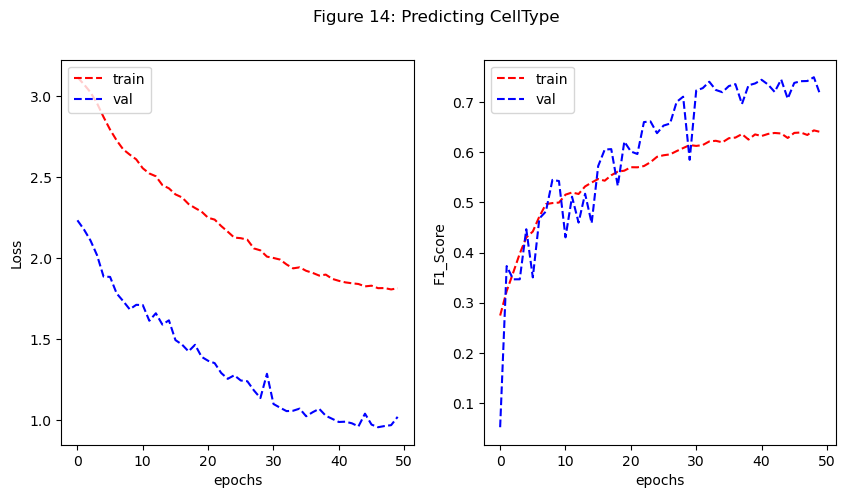

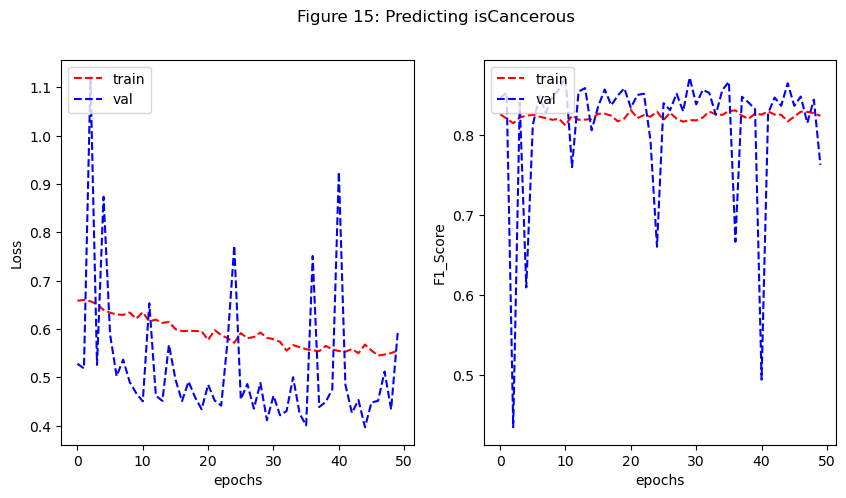

In [ ]:
figindex += 1
plot_learning_curve(History_leNet_final.history['loss'], History_leNet_final.history['val_loss'], 
                    History_leNet_final.history['f1'], History_leNet_final.history['val_f1'], 
                    metric_name='F1_Score', suptitle=f"Figure {figindex}: Predicting CellType")
figindex += 1
plot_learning_curve(History_leNet_final_isCancerous.history['loss'], History_leNet_final_isCancerous.history['val_loss'], 
                    History_leNet_final_isCancerous.history['f1'], History_leNet_final_isCancerous.history['val_f1'], 
                    metric_name='F1_Score', suptitle=f"Figure {figindex}: Predicting isCancerous")


In [ ]:
# Final evaluation
loss, f1 = final_model.evaluate(test_generator)
loss_isCancerous, f1__isCancerous = final_model_isCancerous.evaluate(test_generator_isCancerous)


Found 1823 validated image filenames belonging to 4 classes.
Found 1823 validated image filenames belonging to 2 classes.
 1/68 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - f1: 0.7919 - loss: 1.1026

/home/voyage/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - f1: 0.7431 - loss: 1.0309
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - f1: 0.8701 - loss: 0.3896


## 6. Model Performance and Robustness
## Final Model Accuracy

- For cellType Task:

| Metric   | Goal | Baseline | Improved |
|----------|------|----------|----------|
| F1 Score | ~0.70     |    0.75      |     0.74     |
| Loss     |  n/a    |     0.67     |      1.0309    |

- For both baseline and improved, we beat the scores given by nischaybikramthapa.
    - However, our dataset's imbalance, lack of proper training, proper testing across different distribution subsets detract from the raw scores achieved.
- There is no improvement in F1 score. But there is decrease in Loss
- This suggests the simpler leNet architecture requires comparably more epochs to get similar performance 
    - However, given the F1 score similarlity and decreasing nature of the loss every epoch (for leNet) it would likely have overtaken the baseline. Espeically with the decaying learning rate which would allow for quick learning at start and precise later as to not miss the target (or zigzag around it).
        - This hypothesis is supported by learning curve plots for the improved (Figure 14) which are relatively more stable than the baseline.
- The similar scores between test evaluation and scores seen in training (see the Figure 14) suggest relatively small variance (more generalisation)
- This is supported by our regularisation, augmentation, dropout and class_weights which attempt to reduce impact of class imbalance and promote generalisation (refer to relevant sections for more detail explanation)
- 

---
- For isCancerous Task:

| Metric   | Goal | Baseline | Improved |
|----------|------|----------|----------|
| F1 Score | ~0.86     |     0.8799     |     0.87     |
| Loss     |  n/a    |       0.2775   |      0.3896    |

- Similar dicussion about the goal versus our models as above.
- On the other hand, for isCancerous there are improvements in F1 score and loss.
- Similar discussion about leNet and robust and generalisation techniques (from above) apply here.
- However:
    1. Imbalanced set
    2. All cancerous is one cellType
- These properties/qualities certainly also exist in the validation and test set.
    - Additionally, the cellType model's better performance on majority classes suggests (given similar model architecture and training process) that isCancerous could be similarly better at detecting isCancerous vs notCancerous. But the imbalance in test and validation has allowed this to hide from the f1 score.


- Ultimately, the biggest issue was lack of computational power to do extensive(or even adequate) model training and hyperparameter training which led the improved models to be lack luster.




## 7. Extending using unlabeled data
## Using semi-supervised self-label
- https://www.altexsoft.com/blog/semi-supervised-learning/
- https://machinelearningmastery.com/semi-supervised-learning-with-label-propagation/
- We will use our cellType model to predict the cellTypes for the unlabelled data
- Then added the predictions with 0.90+ probability (entropy) to the data for training

## Issues
- We need a good cellType model. Otherwise we will be training no bad data (with wrong labels)


## What we got
- Firstly, the distribution of unlabelled data (cancerous or not) is even more imbalanced and for the same classes.
    - This means it would further worsen the imbalance and make model more at risk of overfitting...
    - Therefore, given the already good performance of the isCancerous model via the current dataset and the issues with addding the unlabelled to the main dataset, I decided it might not be of worth.
        - Because, need to do more regularisation and tunning to deal with stronger imbalance.

- For cellType:
    - We use the our model to predict cellTypes and got 1447 examples to add to dataset.
    - However, many problems:
        - Given models limited training these examples cannot exactly be trusted.
        - All the examples are of one cellType. Therefore, it doesn't help with our imbalance
            - Additionally, that cellType is the one we have the most of in the original dataset.
            - Hence suggests to our fears that our model is good at mostly the majority dataset.
            - Which again prompts doubt to the usefulness of the self-labelled data.
            - Thus further training on this new dataset will just add to the imbalance in addition to uncertainity about correctness of labels
            - As such we did not train the model however provide the mechinicsms to do so. This is only for our situation where our computing power did not allow for a good model. Otherwise, self-labelling could certainly have improved the performance of our model.  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB
None


Check if any nulls 
InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64


Summary data statistics 
         InstanceID    patientID     cellType  isCancerous
count   9896.000000  9896.000000  9896.000000  9896.000000
mean   10193.880154    29.762025     1.501516     0.412187
std     6652.912660    17.486553     0.954867     0.492253
min        1.000000     1.000000     0.000000     0.000000
25%     4135.750000    14.000000    

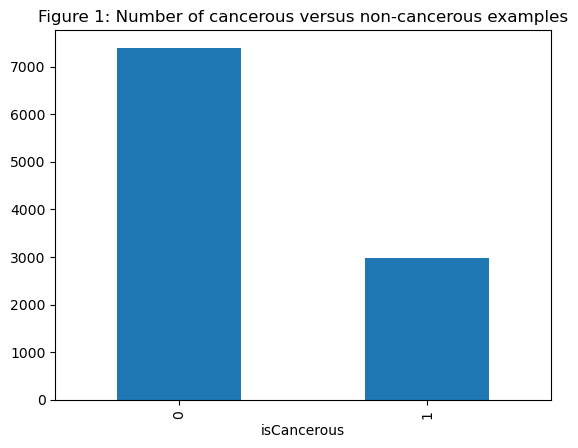

In [54]:
unlabelled_data = pd.read_csv('./Image_classification_data/data_labels_extraData.csv')
print(data.info())
print(f'\n\nCheck if any nulls \n{data.isnull().sum()}')
print(f'\n\nSummary data statistics \n{data.describe()}')
unlabelled_data['isCancerous'].value_counts().plot(kind='bar', title='Figure 1: Number of cancerous versus non-cancerous examples')
plt.show()

In [55]:
unlabelled_patient_dict = {}
for id in unlabelled_data['patientID'].unique():
    unlabelled_patient_dict[id] = unlabelled_data[unlabelled_data['patientID'] == id]

unlabelled_patients_groupByCancerous = {}
unlabelled_patients_groupByNonCancerous = {}
for id, value in unlabelled_patient_dict.items():
    if unlabelled_patient_dict[id]['isCancerous'].eq(1).any():
        unlabelled_patients_groupByCancerous[id] = value
    else:
        unlabelled_patients_groupByNonCancerous[id] = value

print(f'Total number of patients is: {len(unlabelled_patients_groupByCancerous) + len(unlabelled_patients_groupByNonCancerous)}')
print(f'With {len(unlabelled_patients_groupByCancerous)} patients with a cancerous cell versus {len(unlabelled_patients_groupByNonCancerous)} patients with no cancerous cells')


Total number of patients is: 38
With 17 patients with a cancerous cell versus 21 patients with no cancerous cells


Found 10384 validated image filenames.


/home/voyage/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10384/10384 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1447 entries, 0 to 1446
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    1447 non-null   int64 
 1   patientID     1447 non-null   int64 
 2   ImageName     1447 non-null   object
 3   cellTypeName  1447 non-null   object
 4   cellType      1447 non-null   int64 
 5   isCancerous   1447 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 68.0+ KB
None


Check if any nulls 
InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64


Summary data statistics 
         InstanceID    patientID  cellType  isCancerous
count   1447.000000  1447.000000    1447.0  1447.000000
mean    8555.597789    75.997236       2.0     0.966137
std     4016.381312     8.408732       0.0     0.180939
min     1689.000000    65.000000       2.0     0.000000
25%   

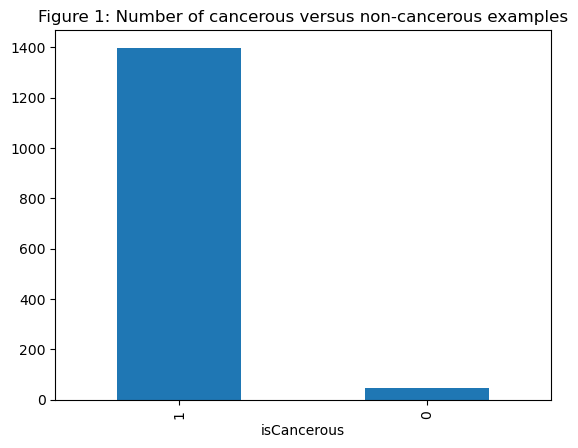

In [ ]:
# Most simple semi-supervised learning to use for unlabelled data 
# https://www.altexsoft.com/blog/semi-supervised-learning/


# unlabelled_data['cellType'] = unlabelled_data['cellType'].astype(str)


# Lets do bit of normalisation with pixel values -> faster training

unlabelled_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

# A hyperparameter?
batch_size = 27

# For cellType classification
unlabelled_generator = unlabelled_datagen.flow_from_dataframe(
    dataframe = unlabelled_data,
    directory = './Image_classification_data/patch_images/',
    x_col = 'ImageName',
    y_col = None,
    target_size=(27, 27),
    batch_size = 1,
    class_mode = None, # Creates onehot encoded labels
    seed = 10,
    shuffle = False, 
)
# https://www.tensorflow.org/tutorials/images/classification
# I checked the img it printed and it is same.
# https://stackoverflow.com/questions/68414509/imagedatagenerator-next-can-this-be-equivalent-to-mnist-train-next-batch
## https://keras.io/api/data_loading/image/
## shuffle: Whether to shuffle the data. Defaults to True. If set to False, sorts the data in alphanumeric order.
preds = final_model.predict(unlabelled_generator)
soft_max_preds = tf.nn.softmax(preds)

# Lets make a new dataframe that includes the new cellTypes

list_result = []

for i in range(0, len(unlabelled_data)):
    pred_prob = np.max(soft_max_preds[i])
    if pred_prob > 0.9: # Given our limited trained model, lets use 0.9
        items = list(unlabelled_data.iloc[i])
        list_result.append(items[0:3] + [''] + [np.argmax(soft_max_preds[i])] + items[3:4])

_data = pd.DataFrame(list_result, columns=data.columns)
print(_data.info())
print(f'\n\nCheck if any nulls \n{_data.isnull().sum()}')
print(f'\n\nSummary data statistics \n{_data.describe()}')
_data['isCancerous'].value_counts().plot(kind='bar', title='Figure 1: Number of cancerous versus non-cancerous examples')
print(_data['isCancerous'].value_counts())
print(_data['cellType'].value_counts())
plt.show()

# Now lets add it to our original dataset. The cellTypeName will be '' for newData items
newData = pd.DataFrame(columns=data.columns)
newData = pd.concat([newData, data, _data], ignore_index=True)

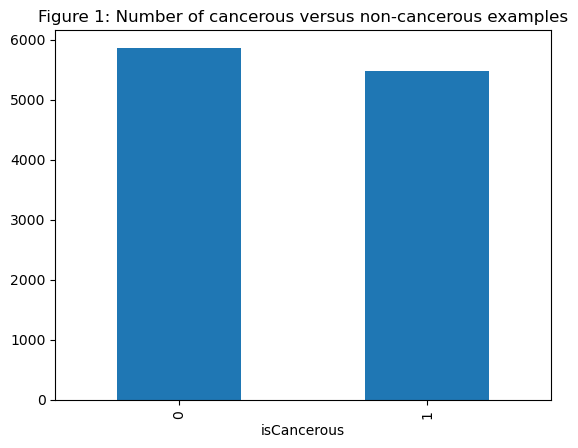

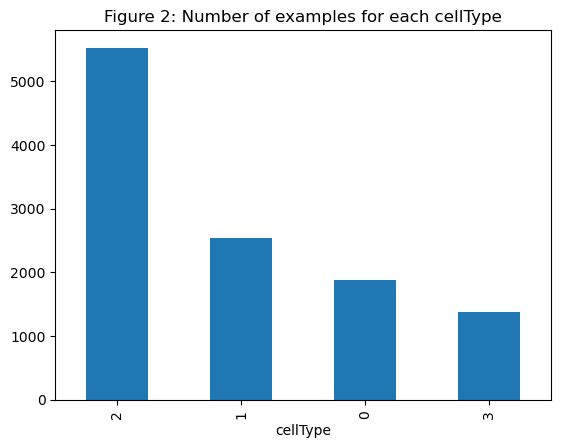

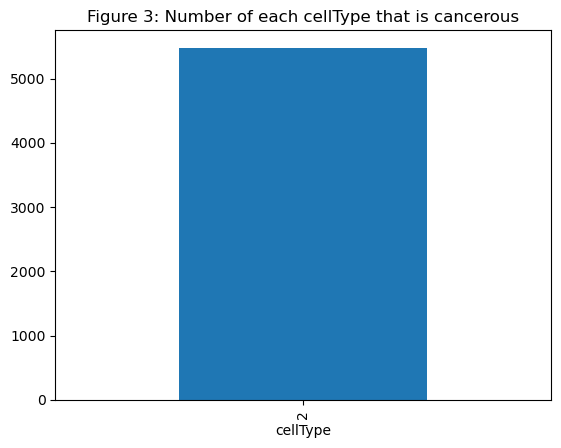

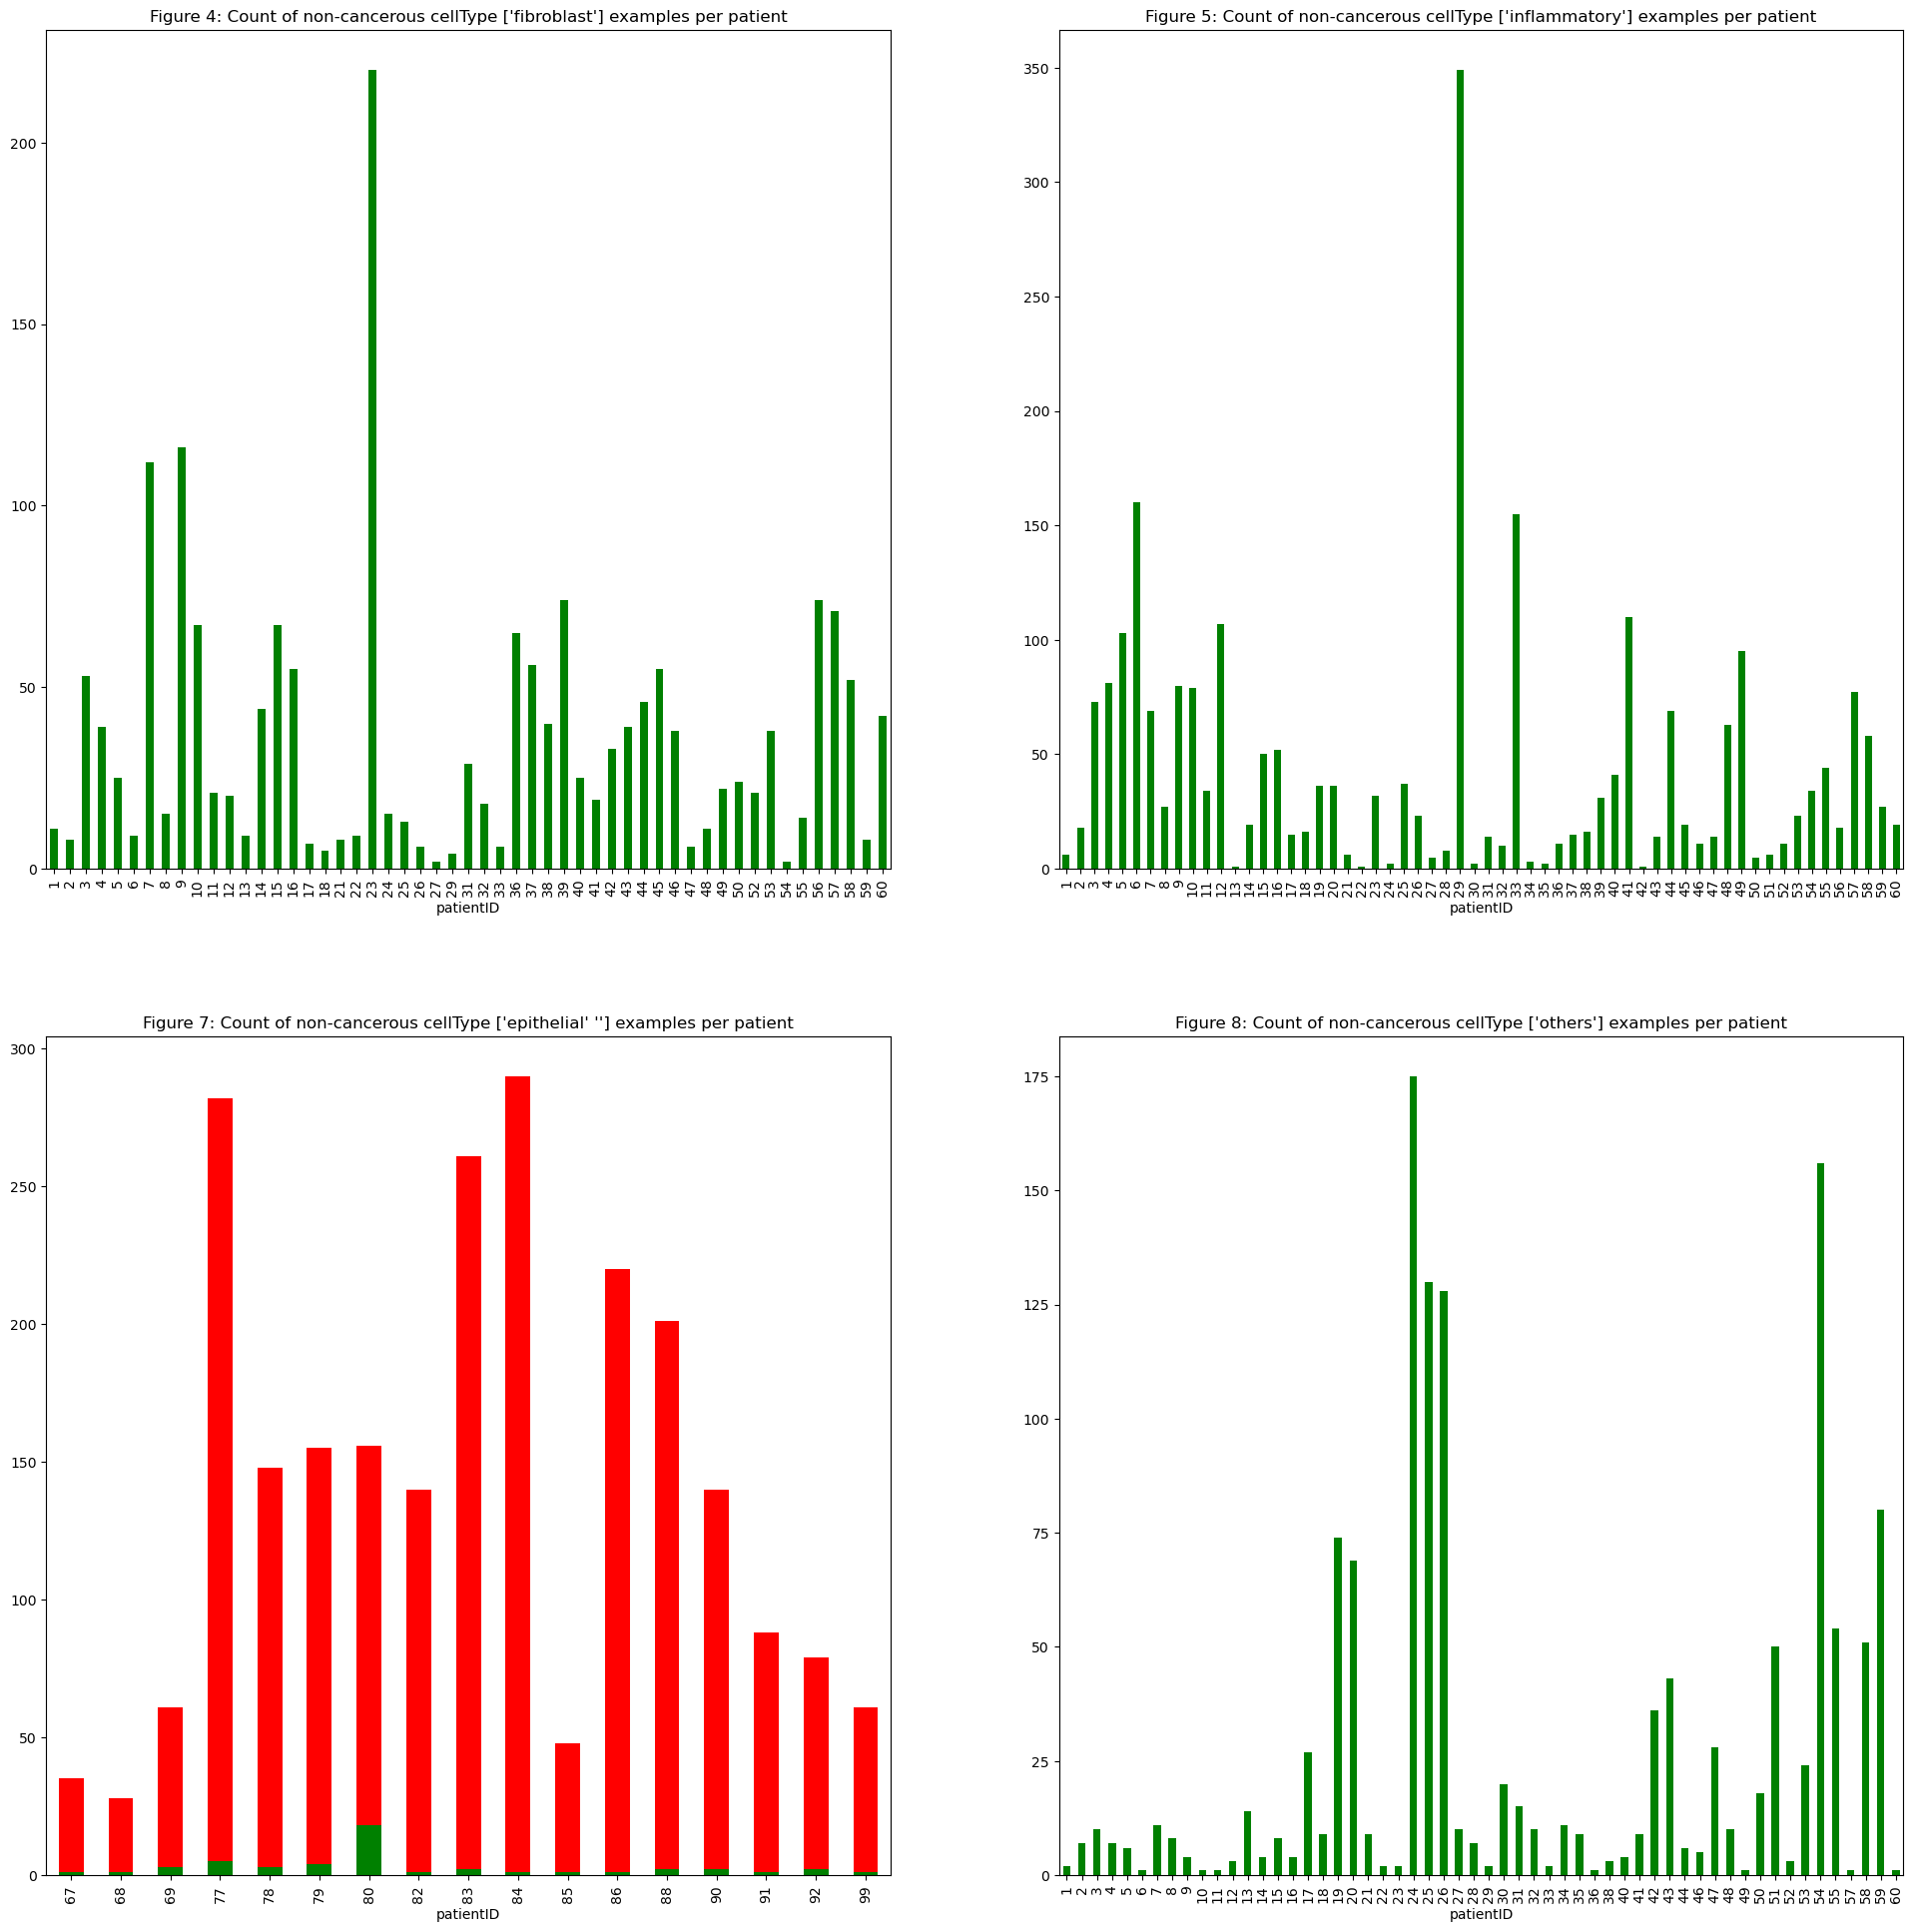

In [217]:
newData['isCancerous'].value_counts().plot(kind='bar', title='Figure 1: Number of cancerous versus non-cancerous examples')
plt.show()
newData['cellType'].value_counts().plot(kind='bar', title='Figure 2: Number of examples for each cellType')
plt.show()
newData[newData['isCancerous'] == 1]['cellType'].value_counts().plot(kind='bar', title='Figure 3: Number of each cellType that is cancerous')
plt.show()


# Below plots the amount of each cellType for each patientID
plt.figure(figsize=(24, 24))
figindex = 3
for i in range(0, 4):
    plt.subplot(2, 2, i + 1)
    # Get rows where cellType = i and get value count of each patientID (how many patients have that cellType)
    byCellTypeCountCancerous = newData[(newData['cellType'] == i) & (newData['isCancerous'] == 1)]['patientID'].value_counts().sort_index()
    byCellTypeCountNotCancerous = newData[(newData['cellType'] == i) & (newData['isCancerous'] == 0)]['patientID'].value_counts().sort_index()
    if len(byCellTypeCountCancerous) > 0:
        figindex += 1
        byCellTypeCountCancerous.plot(kind='bar', color='red', title=f'Figure {figindex}: Count of cancerous cellType {newData[newData['cellType'] == i]['cellTypeName'].unique()} examples per patient')
    if len(byCellTypeCountNotCancerous) > 0:
        figindex += 1
        byCellTypeCountNotCancerous.plot(kind='bar', label='isCancerous = 0', color='green', title=f'Figure {figindex}: Count of non-cancerous cellType {newData[newData['cellType'] == i]['cellTypeName'].unique()} examples per patient')
    
plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2287 entries, 0 to 2286
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    2287 non-null   int64 
 1   patientID     2287 non-null   int64 
 2   ImageName     2287 non-null   object
 3   cellTypeName  2287 non-null   object
 4   cellType      2287 non-null   int64 
 5   isCancerous   2287 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 107.3+ KB
None


Check if any nulls 
InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64


Summary data statistics 
         InstanceID    patientID     cellType  isCancerous
count   2287.000000  2287.000000  2287.000000  2287.000000
mean    8811.514648    76.085702     1.971141     0.876257
std     4245.033222     8.476337     0.238557     0.329360
min     1642.000000    61.000000     0.000000     0.000000
25%     5839.500000    67.000000    

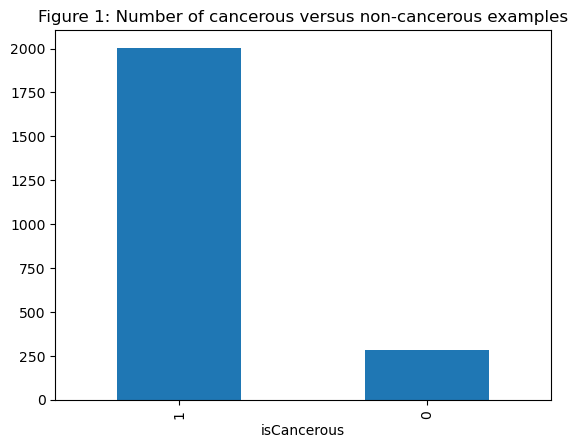

In [196]:

o = []
o.append(items[0:3] + ['hi', 'bye'] + items[3:4])
# list_result[0][4]
# list_result[0][3]

In [197]:
o

[[12681, 61, '12681.png', 'hi', 'bye', 0]]

In [186]:
items = list(unlabelled_data.iloc[0])

In [198]:
items

[12681, 61, '12681.png', 0]

In [172]:
test

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,132,5,132.png,fibroblast,0,0
1,133,5,133.png,fibroblast,0,0
2,134,5,134.png,fibroblast,0,0
3,135,5,135.png,fibroblast,0,0
4,136,5,136.png,fibroblast,0,0
...,...,...,...,...,...,...
1818,20401,35,20401.png,others,3,0
1819,20402,35,20402.png,others,3,0
1820,20403,35,20403.png,others,3,0
1821,20404,35,20404.png,others,3,0


In [ ]:
# Appendix



# Plot of images related to each patient

# for i in range(0, 3):
#     patient = patient_dict[i]
#     num = len(patient)
#     col = 5
#     row = math.ceil(num/col)
#     plt.figure(figsize=(col * 4, row * 4))
#     for j in range(0, len(patient)):
#         # print(j)
#         image_path = patient.iloc[j]['ImageName']
#         # print(image_path)
#         im = imread(f'./Image_classification_data/patch_images/{image_path}', as_gray=True, plugin=None)
#         # print('yes')
#         plt.subplot(num, col, j + 1)
#         plt.title(f'{patient.iloc[j]['InstanceID']}, Cell = {patient.iloc[j]['cellTypeName']}')
#         plt.imshow(im, cmap=plt.cm.gray)
#         plt.axis('off')
#     plt.tight_layout(pad=0.5, h_pad=0.2, w_pad=0.2)
#     plt.show()

   